##Import statements and load data

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import cartopy.crs as ccrs

from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from cartopy.io.img_tiles import MapboxTiles

%matplotlib inline

In [2]:
INPUT_FILE = '../data/trip_data_1_full.csv'
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

# Number of time slices to split a day into
NFRAMES = 24

LAT_MIN, LAT_MAX = 40.76041, 40.76507
LON_MIN, LON_MAX = -73.98164, -73.97653
RECT = [LON_MIN, LON_MAX, LAT_MIN, LAT_MAX]

def filter_df(df, rect, dir='pickup'):
    ''' Filters a dataframe object based on location
    '''
    df = df[(df['{}_longitude'.format(dir)] >= rect[0]) &
            (df['{}_longitude'.format(dir)] <= rect[1]) &
            (df['{}_latitude'.format(dir)]  >= rect[2]) &
            (df['{}_latitude'.format(dir)]  <= rect[3])]
    return df

# Load and filter data without reading entire csv at once
data_iterator = pd.read_csv(INPUT_FILE, iterator=True, chunksize=10000)
td = pd.concat((filter_df(df, RECT) for df in data_iterator), ignore_index=True)

print 'Data size: ' + str(len(td))

Data size: 188392


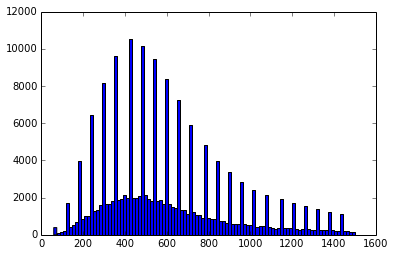

In [3]:
# Cut off long tail
td=td[td['trip_time_in_secs'] < 1500]
trip_time_full = np.asarray(td['trip_time_in_secs'], dtype=np.int)

# Plot trip time histogram
plt.hist(trip_time_full,bins=100)
plt.show()

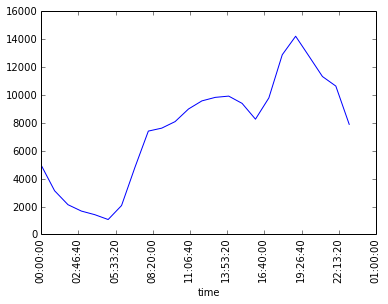

In [4]:
# Convert to correct datetime
td['pickup_datetime'] = pd.to_datetime(td['pickup_datetime'])
td['dropoff_datetime'] = pd.to_datetime(td['dropoff_datetime'])

# Create datetime index
tdi = td.set_index(pd.DatetimeIndex(td['pickup_datetime']))

# Computes time intervals
starts = [dt.time(x / 60, x % 60) for x in range(0, 1440, 1440 / NFRAMES)]
ends = starts[1:] + [starts[0]]

# Plots trips against time
trips = [tdi.between_time(s, e) for s, e in zip(starts, ends)]
plt.plot(starts, map(len, trips))
plt.xticks(rotation='vertical')
plt.show()

##Plot a map color-coding with trip times 

In [5]:
# Add a map using a mapbox template
mapbox_token = 'pk.eyJ1IjoiY2hlbnlhbmciLCJhIjoiNjAwYTI1MDExNDdmYzVkZWY0M2NkNjQyMDJkZjhkOTMifQ.G7P8sFypgRqFW2QNaEZocQ'
mapbox_mapid = 'chenyang.e39eae3e'
tiles = MapboxTiles(mapbox_token, mapbox_mapid)
manhattan_rect = [-74.025, -73.92, 40.70, 40.85]

def draw_frame(frame_no=None):
    # Create new axes
    plt.clf()
    ax = plt.axes(projection=tiles.crs)
    # Load data for current frame
    if frame_no is None:
        data = td
    else:
        data = trips[frame_no]
    dropoff_lat = np.asarray(data['dropoff_latitude'], dtype=np.float)
    dropoff_lon = np.asarray(data['dropoff_longitude'], dtype=np.float)
    trip_time = np.asarray(data['trip_time_in_secs'], dtype=np.int)
    
    # Use the tile's projection for the underlying map.
    ax = plt.axes(projection=tiles.crs)

    # Plot the origin area
    ax.add_patch(Rectangle((LON_MIN, LAT_MIN), LON_MAX-LON_MIN, LAT_MAX-LAT_MIN, 
                 facecolor="blue", alpha=0.3, lw=0,
                 transform=ccrs.PlateCarree()))

    # Add the tiles at zoom level 13.
    ax.add_image(tiles, 13)
    
    # Plot destinations, color coded by travel times
    sc = ax.scatter(dropoff_lon, dropoff_lat, 
                    marker='.', s=15, lw=0, 
                    c=trip_time, cmap=cm.RdYlGn_r,
                    transform=ccrs.PlateCarree())
    
    # Specify a region of interest, in this case, Manhattan.
    ax.set_extent(manhattan_rect, ccrs.PlateCarree())
    
    # Scale and labels
    cur_time = starts[frame_no] if frame_no != None else 'All'
    plt.title('Dropoff Locations at Time: {}'.format(cur_time))
    plt.colorbar(sc).set_label('Trip time in seconds')

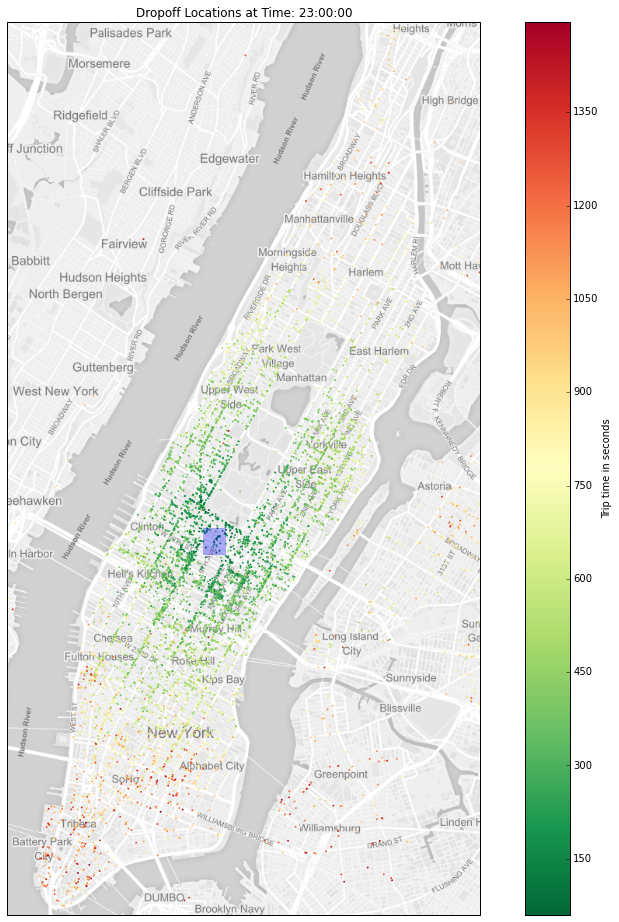

In [7]:
# Render and save animation
plt.clf()
fig = plt.figure(figsize=(16, 16))
anim = animation.FuncAnimation(fig, draw_frame, frames=NFRAMES)
anim.save('animation.gif', writer='imagemagick', fps=4)

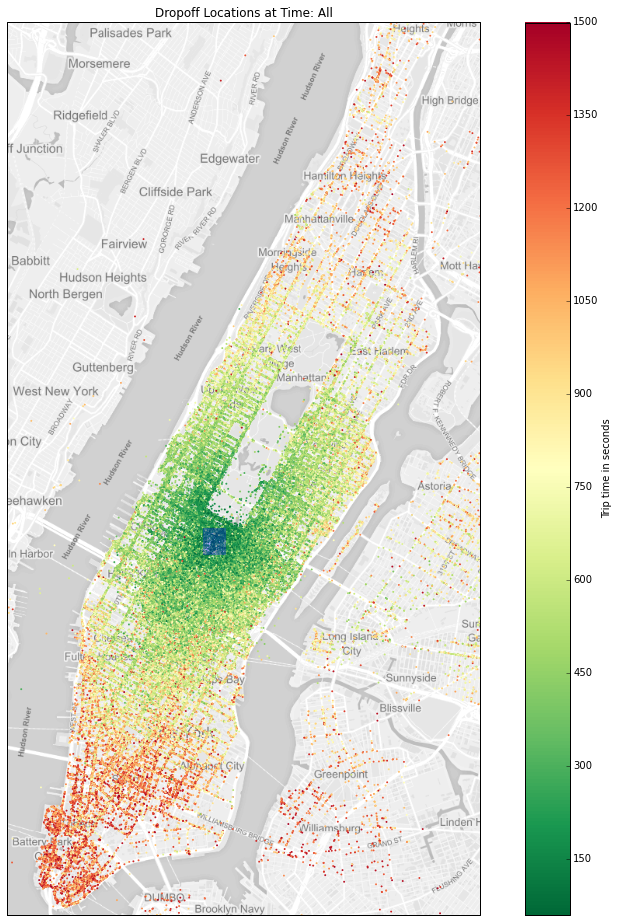

In [8]:
# Plot all trips
fig = plt.figure(figsize=(16, 16))
draw_frame()